# Fashion Product Recommendation using Multimodal Data

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd
import seaborn as sn
import ast
import os
import cv2
import warnings
warnings.filterwarnings(action = 'ignore')

In [12]:
DATASET_PATH = "/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/myntradataset"
print(os.listdir(DATASET_PATH))

['styles.csv', 'images']


In [13]:
DATASET_PATH = "/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/myntradataset"
df = pd.read_csv(DATASET_PATH+"/styles.csv",nrows = 5000,on_bad_lines = "skip")
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [14]:
df['image'] = df.apply(lambda row:str(row['id'])+".jpg",axis = 1).reset_index(drop = True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [15]:
def plot_figures(figures,nrows = 1,ncols = 1,figsize = (8,8)):
    fig,axeslist = plt.subplots(ncols = ncols,nrows = nrows,figsize = figsize)
    for index,title in enumerate(figures):
        axeslist.ravel()[index].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[index].set_title(title)
        axeslist.ravel()[index].set_axis_off()
        
    plt.tight_layout()
    
def img_path(img):
    DATASET_PATH = '/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/myntradataset'
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized   

Feature extraction

In [16]:
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__

'2.16.1'

In [17]:
img_width,img_height,_ = 224,224,3
model_1 = ResNet50(weights = 'imagenet',
                   include_top = False,
                   input_shape = (img_width,img_height,3))
model_1.trainable = False

# Adding Embedding Layer
model_1 = tf.keras.models.Sequential([model_1,GlobalMaxPooling2D()])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
def get_embedding(model,img_name):
    
    img = image.load_img(img_path(img_name),target_size = (224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis = 0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [19]:
emb = get_embedding(model_1, df.iloc[0].image)
emb.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(2048,)

In [20]:
%%time

df_sample = df.copy()
map_embeddings = df_sample['image'].apply(lambda img:get_embedding(model_1,img))
df_embds = map_embeddings.apply(pd.Series)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
df_embds.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.451902,6.704593,0.000000,1.978813,4.560529,3.994556,7.357251,8.840915,0.173763,0.545173,...,1.739148,5.757431,2.347396,23.496443,1.089249,0.000000,9.565609,2.136410,2.623365,18.563391
1,2.160766,13.004475,0.092262,6.950659,5.372176,0.000000,15.559408,2.178860,0.848541,0.146077,...,2.459628,8.469251,5.472925,8.990244,3.187698,0.256655,7.267733,0.000000,6.571848,17.669720
2,0.000000,2.099401,1.121330,5.048748,2.971096,4.301227,3.864698,1.902126,0.494962,4.596429,...,0.000000,16.961676,2.302291,1.838041,0.741311,0.000000,2.888041,2.204799,5.722480,6.089292
3,0.000000,5.336297,1.670132,11.411598,1.258603,0.000000,12.816563,7.772421,0.845031,2.947620,...,29.042677,1.647543,0.176537,0.000000,6.040602,1.806870,10.376255,0.000000,16.299782,16.499523
4,2.663743,15.295507,0.032797,2.476942,6.908781,2.586340,9.054917,7.316333,0.000000,0.000000,...,2.014318,6.502690,3.596582,19.685738,6.044685,0.000000,8.757937,2.211978,4.258551,17.862125


Cosine similarity and other matrix

In [22]:
from sklearn.metrics.pairwise import pairwise_distances

cosine_sim = 1-pairwise_distances(df_embds, metric='cosine')
cosine_sim[:4, :4]

array([[0.99999994, 0.63589454, 0.4957509 , 0.59519005],
       [0.63589454, 1.        , 0.5097841 , 0.737523  ],
       [0.4957509 , 0.5097841 , 1.        , 0.47131705],
       [0.59519005, 0.737523  , 0.47131705, 0.9999993 ]], dtype=float32)

In [23]:
%%time
def get_recommendations(indices,cosine_sim,index,df,top_n = 5):
    sim_index = indices[index]
    sim_scores = list(enumerate(cosine_sim[sim_index]))
    sim_scores = sorted(sim_scores,key = lambda x:x[1],reverse = True)
    sim_scores = sim_scores[1:top_n+1]
    index_rec = [i[0] for i in sim_scores]
    index_sim = [i[1] for i in sim_scores]
    
    return indices.iloc[index_rec].index,index_sim


cosine_sim = 1-pairwise_distances(df_embds, metric='cosine')
indices = pd.Series(range(len(df)),index = df.index)
mean_sim_scores = []
complete_indices = []
complete_scores = []
for index in range(df.shape[0]):    
    try:
        index,sim_array = get_recommendations(indices,cosine_sim,index,df,top_n = 5)
        mean_score = np.mean(sim_array)
        mean_sim_scores.append(mean_score)
        complete_indices.append(index)
        complete_scores.append(sim_array)
    except Exception as ex:
        print(f'Following exception : {ex} occured at the index : {index}')

CPU times: user 36.4 s, sys: 6.71 s, total: 43.1 s
Wall time: 29.2 s


In [24]:
a = [list(i) for i in complete_indices]
sub_cat = [df['subCategory'].iloc[a[index]].to_list() for index in range(df.shape[0])]
mast_cat = [df['masterCategory'].iloc[a[index]].to_list() for index in range(df.shape[0])]
resnet_50 = pd.DataFrame()
resnet_50['id'] = df['id']
resnet_50['recommended_index'] = [list(i) for i in complete_indices]
resnet_50['recommended_scores'] = complete_scores
resnet_50['masterCategory'] = df['masterCategory']
resnet_50['subCategory'] = df['subCategory']
resnet_50['Recommended_master_category'] = mast_cat
resnet_50['Recommended_sub_category'] = sub_cat
resnet_50['mean_recommended_score'] = mean_sim_scores
resnet_50.head(2)

,id,recommended_index,recommended_scores,masterCategory,subCategory,Recommended_master_category,Recommended_sub_category,mean_recommended_score
0,15970,"[3899, 3810, 659, 3610, 1640]","[0.93988883, 0.93344146, 0.919504, 0.91044134,...",Apparel,Topwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Topwear, Topwear, Topwear, Topwear, Topwear]",0.920451
1,39386,"[3522, 3572, 1328, 2926, 459]","[0.8830086, 0.8805389, 0.87981963, 0.87981963,...",Apparel,Bottomwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Bottomwear, Bottomwear, Bottomwear, Bottomwea...",0.880595


In [25]:
def getmatch_score(resnet_50,col,col1):
    
    match_list = []
    for index in range(resnet_50.shape[0]):
        try:
            actual_match = resnet_50[col].iloc[index]
            predicted_match = resnet_50[col1].iloc[index]
            count = 0
            for item in predicted_match:
                if item==actual_match:
                    count+=1
            match_list.append((count/5)*100)
        except Exception as ex:
            print(f'Following exception : {ex} occured at index : {index}')
    
    return match_list

resnet_50['Match_Master_Score'] = getmatch_score(resnet_50,'masterCategory','Recommended_master_category')
resnet_50['Match_Sub_Score'] = getmatch_score(resnet_50,'subCategory','Recommended_sub_category')
resnet_50.head(2)

,id,recommended_index,recommended_scores,masterCategory,subCategory,Recommended_master_category,Recommended_sub_category,mean_recommended_score,Match_Master_Score,Match_Sub_Score
0,15970,"[3899, 3810, 659, 3610, 1640]","[0.93988883, 0.93344146, 0.919504, 0.91044134,...",Apparel,Topwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Topwear, Topwear, Topwear, Topwear, Topwear]",0.920451,100.0,100.0
1,39386,"[3522, 3572, 1328, 2926, 459]","[0.8830086, 0.8805389, 0.87981963, 0.87981963,...",Apparel,Bottomwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Bottomwear, Bottomwear, Bottomwear, Bottomwea...",0.880595,100.0,100.0


In [26]:
resnet_50.head(2)

,id,recommended_index,recommended_scores,masterCategory,subCategory,Recommended_master_category,Recommended_sub_category,mean_recommended_score,Match_Master_Score,Match_Sub_Score
0,15970,"[3899, 3810, 659, 3610, 1640]","[0.93988883, 0.93344146, 0.919504, 0.91044134,...",Apparel,Topwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Topwear, Topwear, Topwear, Topwear, Topwear]",0.920451,100.0,100.0
1,39386,"[3522, 3572, 1328, 2926, 459]","[0.8830086, 0.8805389, 0.87981963, 0.87981963,...",Apparel,Bottomwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Bottomwear, Bottomwear, Bottomwear, Bottomwea...",0.880595,100.0,100.0


<Axes: xlabel='mean_recommended_score', ylabel='Density'>

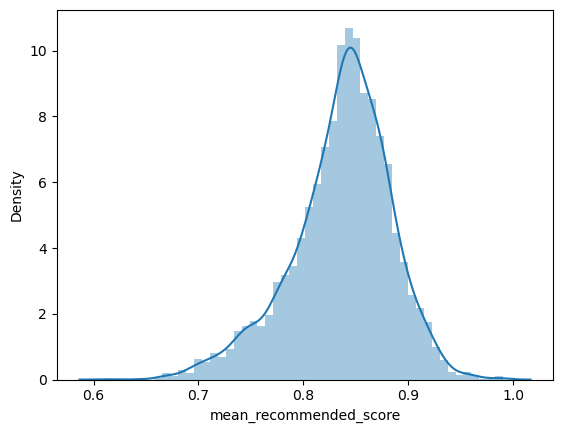

In [27]:
sn.distplot(resnet_50['mean_recommended_score'])

vgg-16


In [28]:
img_width,img_height,_ = 224,224,3
model_2 = VGG16(weights = 'imagenet',
                   include_top = False,
                   input_shape = (img_width,img_height,3))
model_2.trainable = False

# Adding Embedding Layer
model_2 = tf.keras.models.Sequential([model_2,GlobalMaxPooling2D()])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
vgg_emb = get_embedding(model_2, df.iloc[0].image)
vgg_emb.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


(512,)

In [30]:
%%time

df_sample = df.copy()
map_embeddings = df_sample['image'].apply(lambda img:get_embedding(model_2,img))
df_embds_vgg16 = map_embeddings.apply(pd.Series)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 

recommendation using vgg-16

In [31]:
%%time
def get_recommendations(indices,cosine_sim,index,df,top_n = 5):
    sim_index = indices[index]
    sim_scores = list(enumerate(cosine_sim[sim_index]))
    sim_scores = sorted(sim_scores,key = lambda x:x[1],reverse = True)
    sim_scores = sim_scores[1:top_n+1]
    index_rec = [i[0] for i in sim_scores]
    index_sim = [i[1] for i in sim_scores]
    
    return indices.iloc[index_rec].index,index_sim


cosine_sim = 1-pairwise_distances(df_embds_vgg16, metric='cosine')
indices = pd.Series(range(len(df)),index = df.index)
mean_sim_scores_vgg = []
complete_indices_vgg = []
complete_scores_vgg = []
for index in range(df.shape[0]):    
    try:
        index,sim_array = get_recommendations(indices,cosine_sim,index,df,top_n = 5)
        mean_score = np.mean(sim_array)
        mean_sim_scores_vgg.append(mean_score)
        complete_indices_vgg.append(index)
        complete_scores_vgg.append(sim_array)
    except Exception as ex:
        print(f'Following exception : {ex} occured at the index : {index}')

CPU times: user 23.6 s, sys: 1.81 s, total: 25.4 s
Wall time: 22.5 s


In [32]:
a = [list(i) for i in complete_indices_vgg]
sub_cat = [df['subCategory'].iloc[a[index]].to_list() for index in range(df.shape[0])]
mast_cat = [df['masterCategory'].iloc[a[index]].to_list() for index in range(df.shape[0])]
vgg_16 = pd.DataFrame()
vgg_16['id'] = df['id']
vgg_16['recommended_index'] = [list(i) for i in complete_indices_vgg]
vgg_16['recommended_scores'] = complete_scores_vgg
vgg_16['masterCategory'] = df['masterCategory']
vgg_16['subCategory'] = df['subCategory']
vgg_16['Recommended_master_category'] = mast_cat
vgg_16['Recommended_sub_category'] = sub_cat
vgg_16['mean_recommended_score'] = mean_sim_scores_vgg
vgg_16.head(2)

,id,recommended_index,recommended_scores,masterCategory,subCategory,Recommended_master_category,Recommended_sub_category,mean_recommended_score
0,15970,"[3610, 3810, 4746, 428, 3477]","[0.8798212, 0.87364227, 0.85525584, 0.85349643...",Apparel,Topwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Topwear, Topwear, Topwear, Topwear, Topwear]",0.863142
1,39386,"[3522, 459, 4706, 4414, 983]","[0.8967725, 0.8566927, 0.8480214, 0.8403821, 0...",Apparel,Bottomwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Bottomwear, Bottomwear, Bottomwear, Bottomwea...",0.855727


In [33]:
def getmatch_score(data,col,col1):
    
    match_list = []
    for index in range(data.shape[0]):
        try:
            actual_match = data[col].iloc[index]
            predicted_match = data[col1].iloc[index]
            count = 0
            for item in predicted_match:
                if item==actual_match:
                    count+=1
            match_list.append((count/5)*100)
        except Exception as ex:
            print(f'Following exception : {ex} occured at index : {index}')
    
    return match_list

vgg_16['Match_Master_Score'] = getmatch_score(vgg_16,'masterCategory','Recommended_master_category')
vgg_16['Match_Sub_Score'] = getmatch_score(vgg_16,'subCategory','Recommended_sub_category')
vgg_16.head(2)

,id,recommended_index,recommended_scores,masterCategory,subCategory,Recommended_master_category,Recommended_sub_category,mean_recommended_score,Match_Master_Score,Match_Sub_Score
0,15970,"[3610, 3810, 4746, 428, 3477]","[0.8798212, 0.87364227, 0.85525584, 0.85349643...",Apparel,Topwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Topwear, Topwear, Topwear, Topwear, Topwear]",0.863142,100.0,100.0
1,39386,"[3522, 459, 4706, 4414, 983]","[0.8967725, 0.8566927, 0.8480214, 0.8403821, 0...",Apparel,Bottomwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Bottomwear, Bottomwear, Bottomwear, Bottomwea...",0.855727,100.0,100.0


<Axes: xlabel='mean_recommended_score', ylabel='Density'>

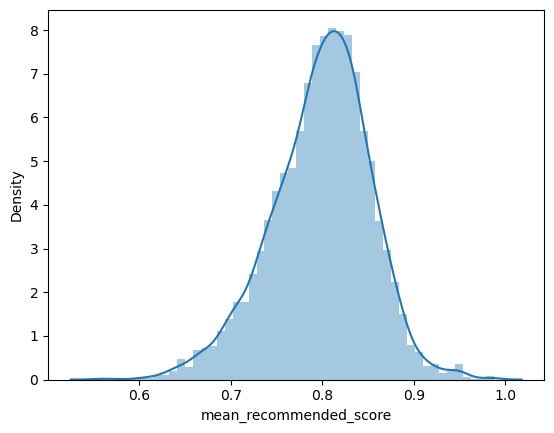

In [34]:
sn.distplot(vgg_16['mean_recommended_score'])

vgg19

In [35]:
img_width,img_height,_ = 224,224,3
model_3 = VGG19(weights = 'imagenet',
                   include_top = False,
                   input_shape = (img_width,img_height,3))
model_3.trainable = False

# Adding Embedding Layer
model_3 = tf.keras.models.Sequential([model_3,GlobalMaxPooling2D()])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [36]:
vgg_emb_19 = get_embedding(model_3, df.iloc[0].image)
vgg_emb_19.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


(512,)

In [37]:
%%time

df_sample = df.copy()
map_embeddings = df_sample['image'].apply(lambda img:get_embedding(model_3,img))
df_embds_vgg19 = map_embeddings.apply(pd.Series)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/ste

Recomenndation using vgg19

In [38]:
def get_recommender(indices,cosine_sim,idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

cosine_sim = 1-pairwise_distances(df_embds_vgg19, metric='cosine')
indices = pd.Series(range(len(df)),index = df.index)
complete_sim_score = []
mean_sim_vgg19 = []
complete_vgg19_index = []
for index in range(df.shape[0]):
    try:
        index_arr,sim_score_vgg19 = get_recommender(indices,cosine_sim,index, df, top_n = 5)
        mean_sim_vgg19.append(np.mean(sim_score_vgg19))
        complete_sim_score.append(sim_score_vgg19)
        complete_vgg19_index.append(index_arr)
    except Exception as ex:
        print(f'Following exception : {ex} occured at the following index : {index}')

In [39]:
a = [list(i) for i in complete_vgg19_index]
sub_cat = [df['subCategory'].iloc[a[index]].to_list() for index in range(df.shape[0])]
mast_cat = [df['masterCategory'].iloc[a[index]].to_list() for index in range(df.shape[0])]
vgg_19 = pd.DataFrame()
vgg_19['id'] = df['id']
vgg_19['recommended_index'] = [list(i) for i in complete_vgg19_index]
vgg_19['recommended_scores'] = complete_sim_score
vgg_19['masterCategory'] = df['masterCategory']
vgg_19['subCategory'] = df['subCategory']
vgg_19['Recommended_master_category'] = mast_cat
vgg_19['Recommended_sub_category'] = sub_cat
vgg_19['mean_recommended_score'] = mean_sim_vgg19
vgg_19.head(2)

,id,recommended_index,recommended_scores,masterCategory,subCategory,Recommended_master_category,Recommended_sub_category,mean_recommended_score
0,15970,"[3810, 659, 3899, 4746, 3610]","[0.8881134, 0.88324904, 0.8804203, 0.85814106,...",Apparel,Topwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Topwear, Topwear, Topwear, Topwear, Topwear]",0.872597
1,39386,"[3522, 1328, 2926, 1339, 4706]","[0.88924813, 0.852409, 0.852409, 0.84884334, 0...",Apparel,Bottomwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Bottomwear, Bottomwear, Bottomwear, Bottomwea...",0.857505


In [40]:
def getmatch_score(data,col,col1):
    
    match_list = []
    for index in range(data.shape[0]):
        try:
            actual_match = data[col].iloc[index]
            predicted_match = data[col1].iloc[index]
            count = 0
            for item in predicted_match:
                if item==actual_match:
                    count+=1
            match_list.append((count/5)*100)
        except Exception as ex:
            print(f'Following exception : {ex} occured at index : {index}')
    
    return match_list

vgg_19['Match_Master_Score'] = getmatch_score(vgg_19,'masterCategory','Recommended_master_category')
vgg_19['Match_Sub_Score'] = getmatch_score(vgg_19,'subCategory','Recommended_sub_category')
vgg_19.head(2)

,id,recommended_index,recommended_scores,masterCategory,subCategory,Recommended_master_category,Recommended_sub_category,mean_recommended_score,Match_Master_Score,Match_Sub_Score
0,15970,"[3810, 659, 3899, 4746, 3610]","[0.8881134, 0.88324904, 0.8804203, 0.85814106,...",Apparel,Topwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Topwear, Topwear, Topwear, Topwear, Topwear]",0.872597,100.0,100.0
1,39386,"[3522, 1328, 2926, 1339, 4706]","[0.88924813, 0.852409, 0.852409, 0.84884334, 0...",Apparel,Bottomwear,"[Apparel, Apparel, Apparel, Apparel, Apparel]","[Bottomwear, Bottomwear, Bottomwear, Bottomwea...",0.857505,100.0,100.0


<Axes: xlabel='mean_recommended_score', ylabel='Density'>

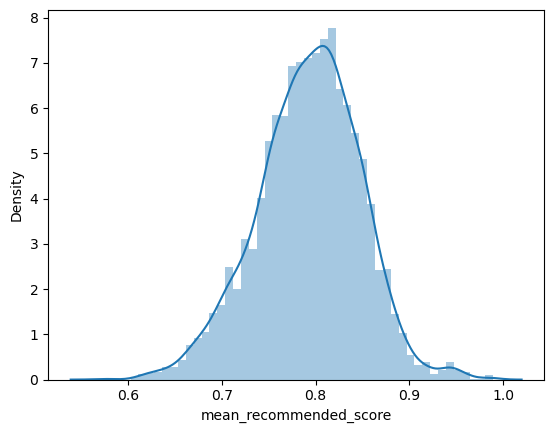

In [41]:
sn.distplot(vgg_19['mean_recommended_score'])